<a href="https://colab.research.google.com/github/Lourdes-Tolotto/ML/blob/main/TP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd

!pip install kneed

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv")
print(df.head())
print()
df.info()
print()

df = df.rename(columns={"Unnamed: 0": "State"})

features = df.drop(columns='State')


   Unnamed: 0  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB



In [57]:
from scipy.stats import normaltest

# Se analiza un conjunto de datos para determinar si tienen distribucion normal

def print_hist(data, data_name, ax):
    
    # Con este criterio se asume que los datos tienen una distribucion normal
    # si p_value>0.5
    stat, p_value = normaltest(data)
    
    if p_value > 0.05: 
      normal = True
      sns.histplot(data, kde=True, ax=ax, color='green')
      ax.set_title(data_name + ' (Posee D. Normal)')
    else: 
      normal = False
      sns.histplot(data, kde=True, ax=ax, color='red')
      ax.set_title(data_name + ' (NO Posee D. Normal)')
    
    return normal
    

In [58]:
# Imprime cada feature del dataset informando si tiene distribucion normal o no

def DF_analysis(df, fig_fils, fig_cols):
    
    features = df.columns
    fig, axes = plt.subplots(fig_fils, fig_cols, figsize=(24,6))
    plt.subplots_adjust(hspace=1, wspace=0.5)
    axes = axes.ravel()

    count = 0

    """for feature, ax in zip(features, axes):
        if feature != avoid_name :
          if print_hist(df[feature], feature, ax)==True : count = count + 1
    """
    for feature, ax in zip(features, axes):
        if print_hist(df[feature], feature, ax)==True : count = count + 1

    print("Features con distribución normal: ",count)

    fig.suptitle('Analisis de cada feature')
    #axes[1].remove()
    plt.show()

In [59]:
def cluster_plot(features,cluster):

  names = features.columns.values

  fig, axes = plt.subplots(len(names), len(names)-1,
                          figsize=(18,20))
  plt.subplots_adjust(hspace=0.3)

  fil = 0
  col = 0

  for i in range(0,len(names)):
    for j in range(0,len(names)):
      
      if i != j:

        for q in range(0,len(names)):
          if q!=i and q!= j:
            data_f = features.drop(columns = names[q])

        sns.scatterplot(ax = axes[fil,col], x = names[i], 
                  y = names[j],
                  data = data_f,
                  hue = cluster,
                  palette='rainbow').set_title('Visualización del clustering')

        col = col + 1
        if col == 3: 
          fil = fil + 1
          col = 0


Features con distribución normal:  3


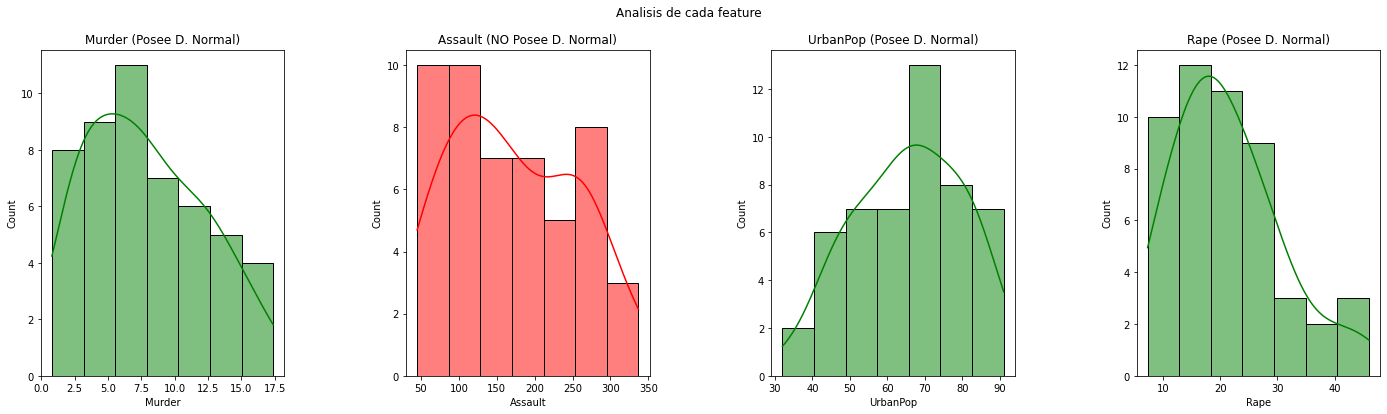

In [60]:
DF_analysis(features,1,4)

In [61]:
# Se estandarizan los features (media 0 y desviación estandar 1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


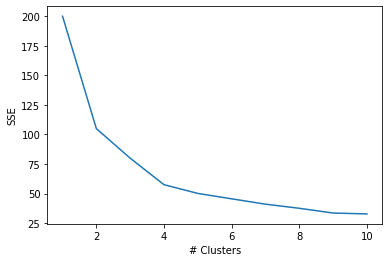

4


In [62]:
# Se busca el # de cluster óptimo para el dataset

kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300,
            "random_state": 42}

sse = []
for k in range(1, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs) 
 kmeans.fit(scaled_features) 
 sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel("# Clusters")
plt.ylabel("SSE")
plt.show()

# Se localiza el codo de la curva, que corresponde al # de clusters

kl = KneeLocator( range(1, 11), sse, curve="convex", direction="decreasing")

ep = kl.elbow    # cantidad de clusters
print(ep)


Inercia (medida de un correcto agrupamiento de datos mientras más cercano a 0 mejor)  57.55425863091105

Cantidad de iteraciones necesarias para converger:  7



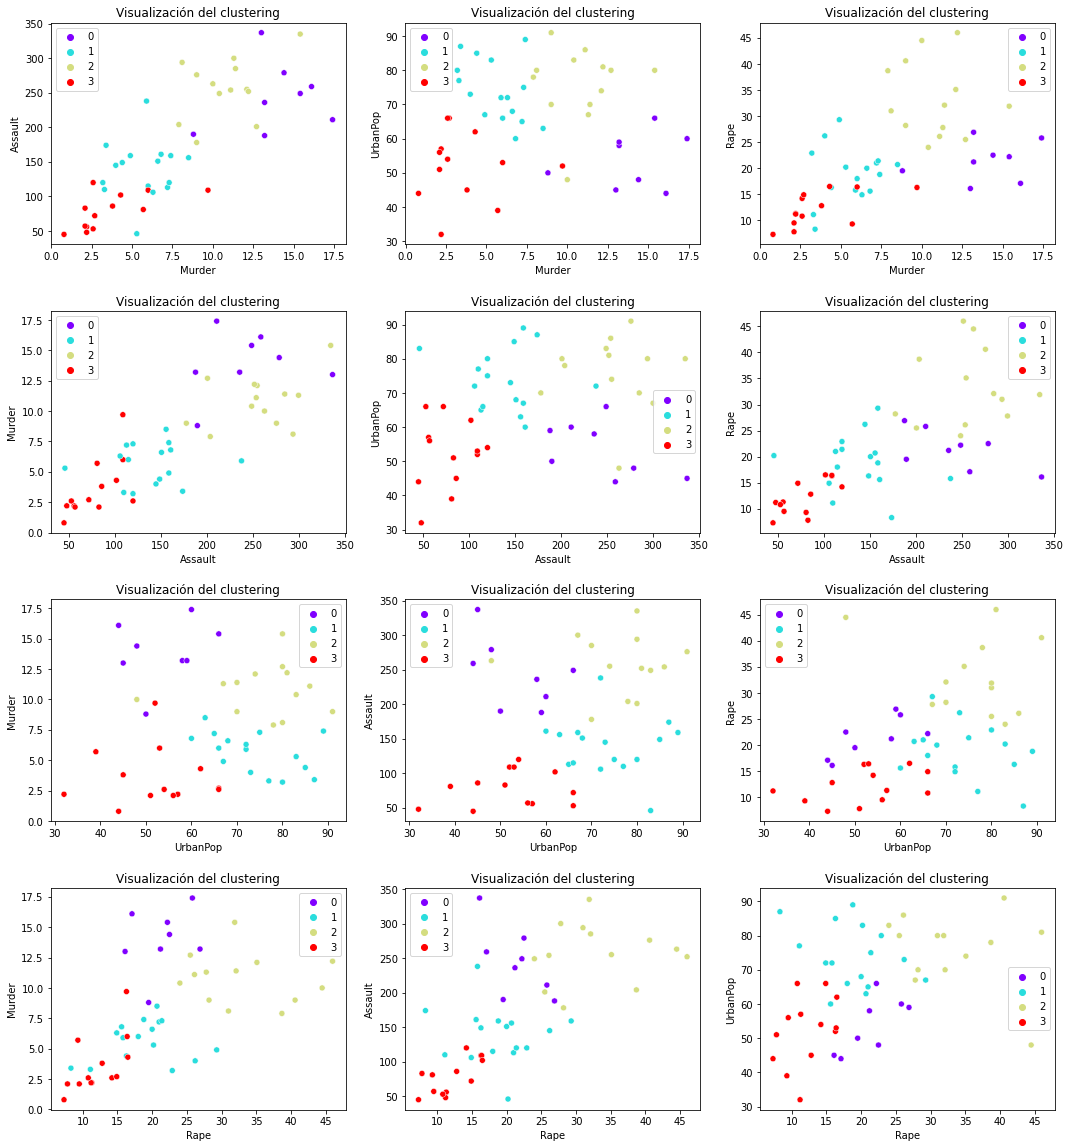

In [63]:
# Se establece el número de clusters en base a ep, definido como el valor
# óptimo de clusters

kmeans = KMeans(init="random", n_clusters = ep, n_init = 10, 
                max_iter = 300, random_state = 42)

kmeans.fit(scaled_features)

# Valor mas bajo de SSE

print('Inercia (medida de un correcto agrupamiento de datos mientras más cercano a 0 mejor) ',
      kmeans.inertia_)
print()

# número de iteciones hasta lograr convergencia

print('Cantidad de iteraciones necesarias para converger: ', 
      kmeans.n_iter_)
print()

cluster_plot(features, kmeans.labels_)



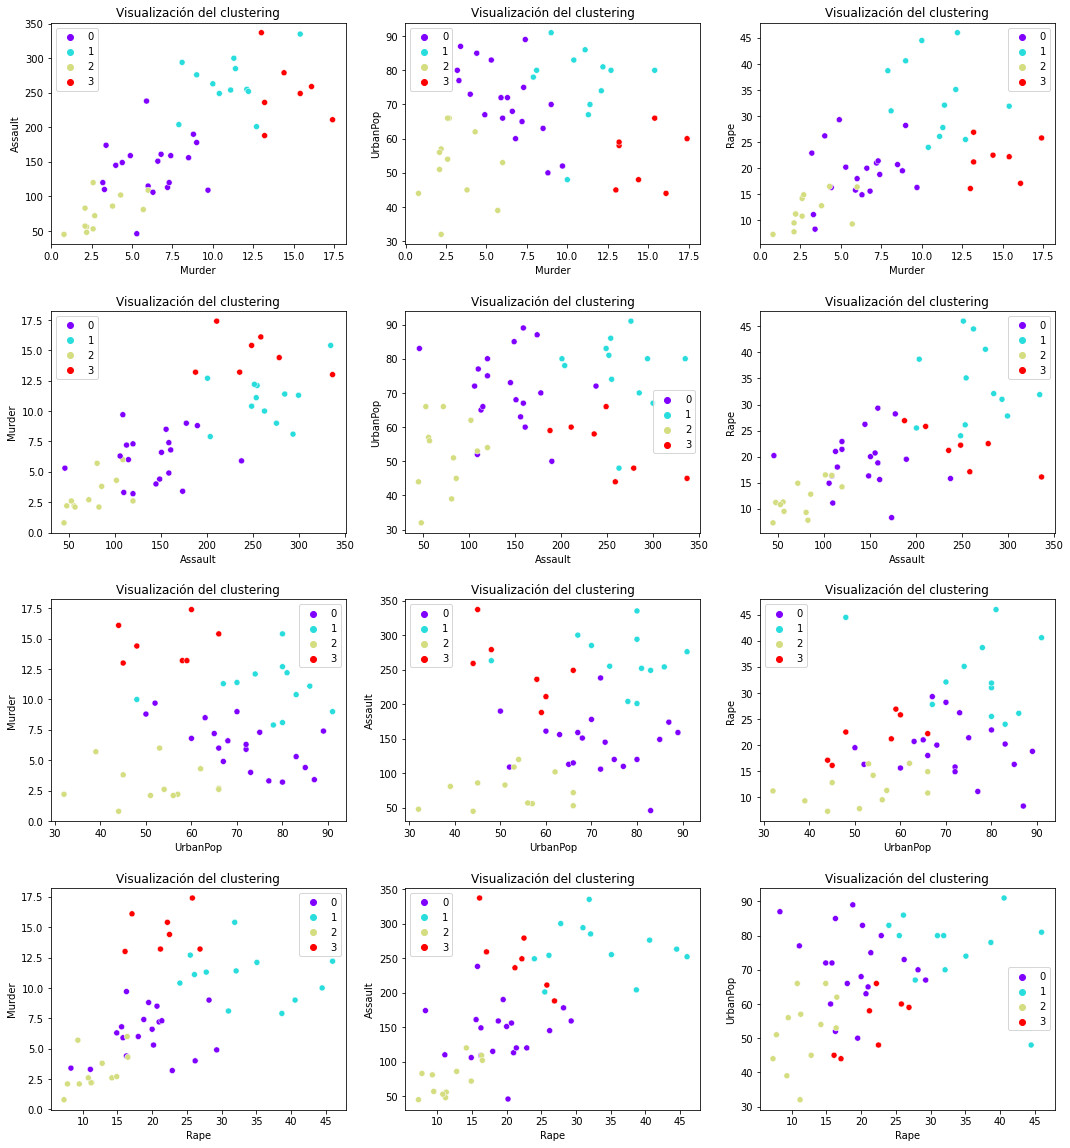

In [64]:
# Clustering utilizando Agglomerative Clustering

from sklearn.cluster import AgglomerativeClustering

Agg_model = AgglomerativeClustering(n_clusters=ep, 
                    affinity='euclidean', linkage='ward')
Agg_model.fit(scaled_features)

cluster_plot(features, Agg_model.labels_)

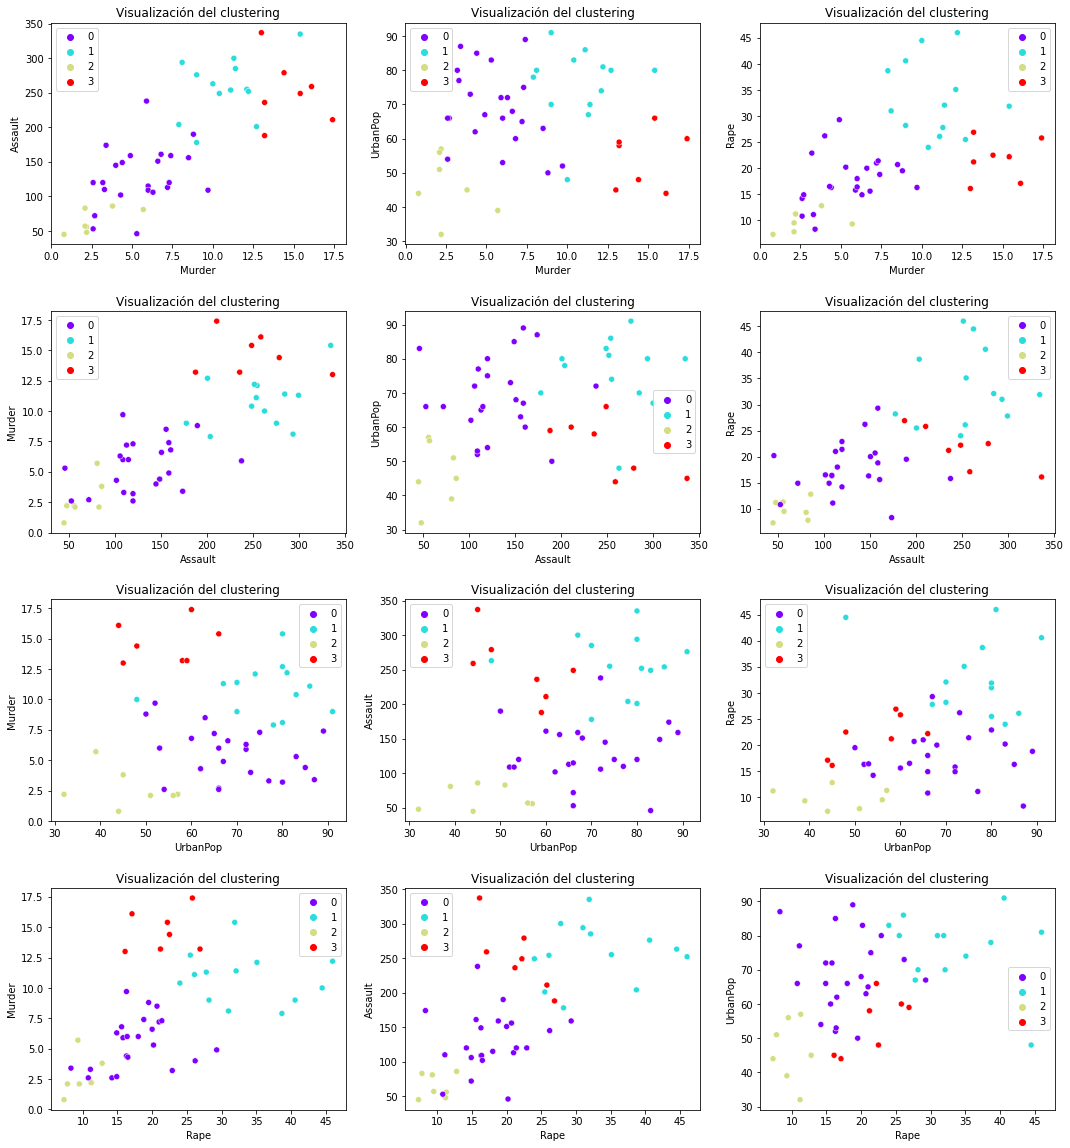

In [65]:
# Clustering utilizando Birch Clustering

from sklearn.cluster import Birch

model_birch = Birch(branching_factor = 10, n_clusters = ep, 
                    threshold = 0.3)

model_birch.fit(scaled_features)

cluster_plot(features,model_birch.predict(scaled_features))

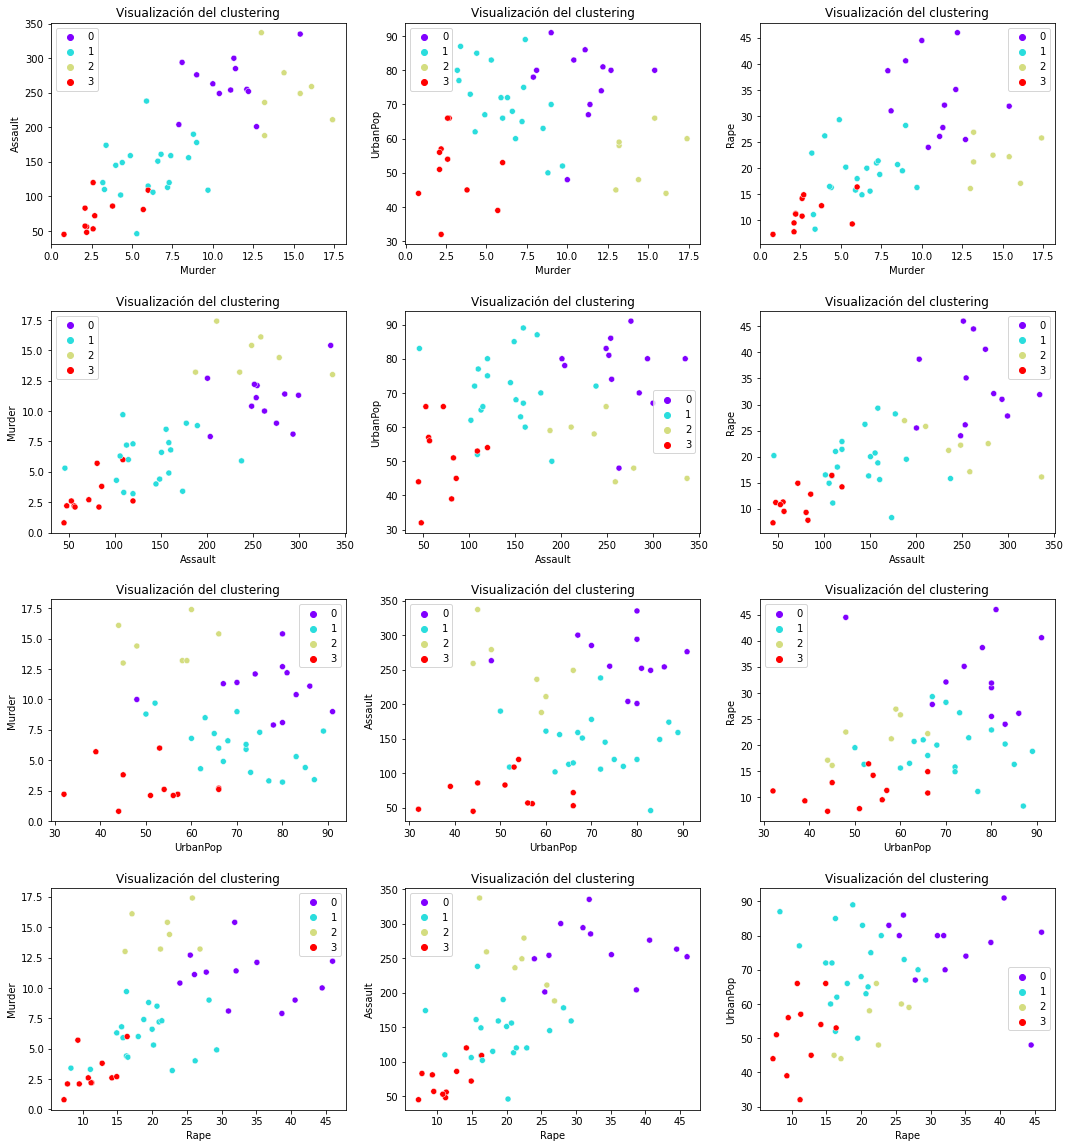

In [66]:
# Clustering utilizando Spectral Clustering

from sklearn.cluster import SpectralClustering

model_spectral = SpectralClustering(n_clusters=ep, assign_labels='discretize',
            random_state=0).fit(scaled_features)

cluster_plot(features,model_spectral.labels_)


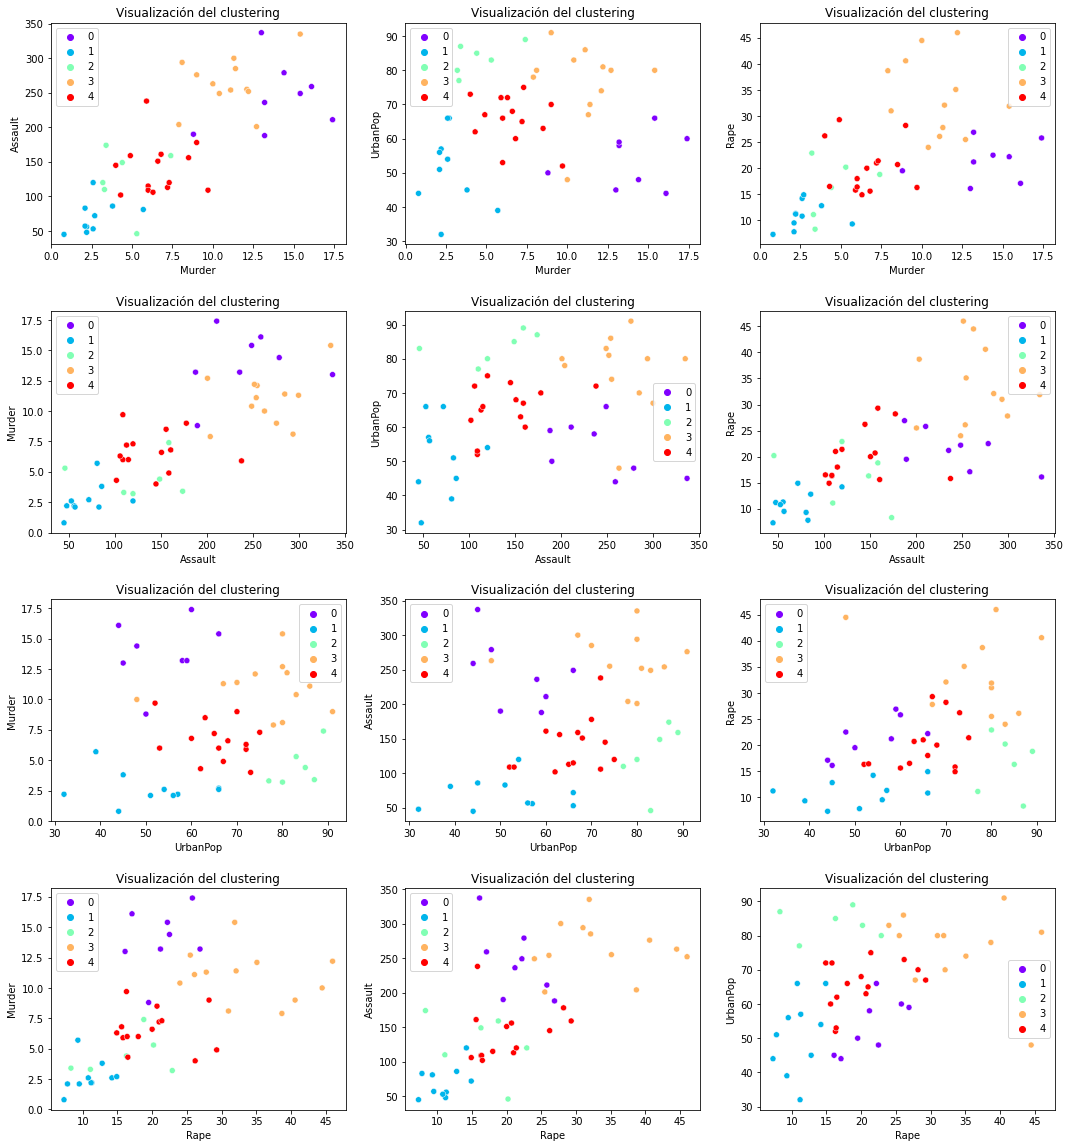

In [67]:
# Clustering utilizando AffinityPropagation Clustering

from sklearn.cluster import AffinityPropagation

model_affinity = AffinityPropagation(damping=0.5, max_iter=500, 
                                     affinity="euclidean", random_state=0)


model_affinity.fit(scaled_features)

cluster_plot(features,model_affinity.fit_predict(scaled_features))  


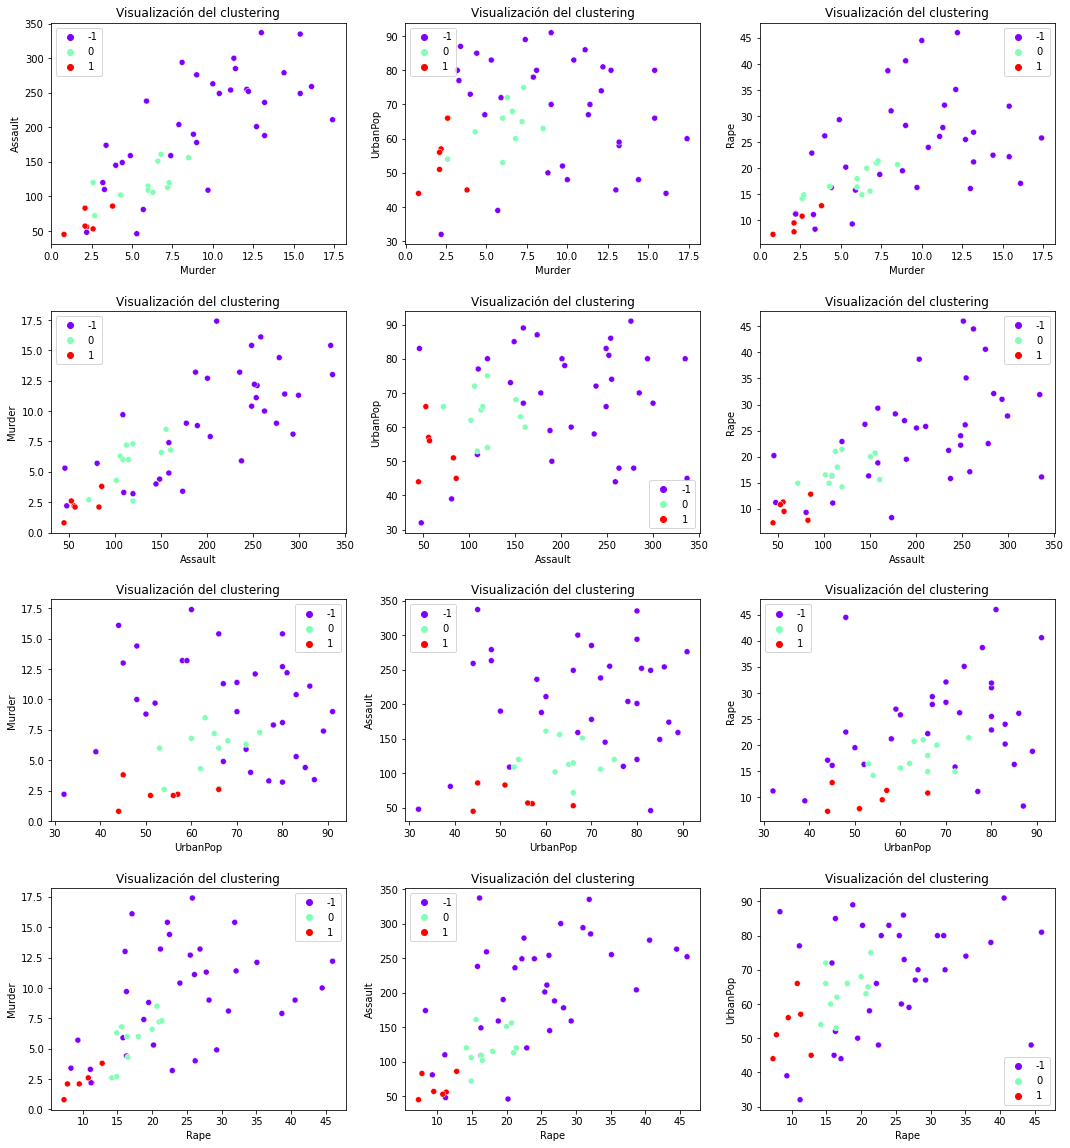

In [68]:
# Clustering utilizando Optics Clustering

from sklearn.cluster import OPTICS

model_optics = OPTICS(min_samples=5, cluster_method= 'dbscan',
                       eps=0.8).fit(scaled_features)

cluster_plot(features,model_optics.labels_)

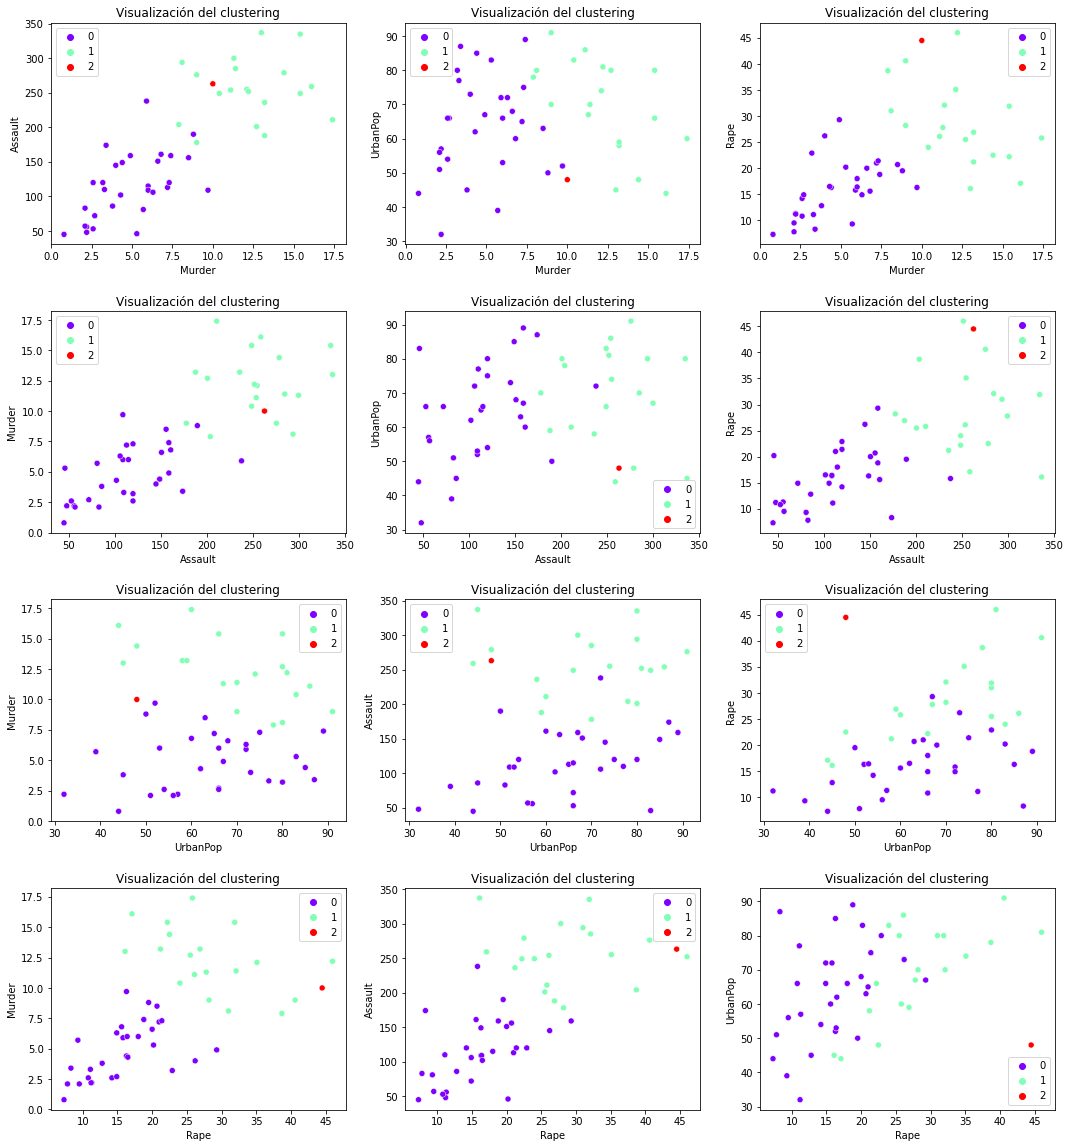

In [69]:
# Clustering utilizando Mean shift Clustering

from sklearn.cluster import MeanShift

model_mean = MeanShift(bandwidth = 1.8, cluster_all= True, 
                       min_bin_freq = 1, max_iter = 500)
model_mean.fit(scaled_features)

cluster_plot(features,model_mean.labels_)